In [69]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GroupKFold, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [70]:
# Utils 

def dropBiasFeatures(df):
    df = df.drop(['populationDensity',
                        'distanceToUrban',
                        'distanceRo',
                        'urbanArea',
                        'airesProtegees'
                        ], axis = 1)
    return df

In [71]:
# 1. Load data

df = pd.read_csv("/home/egodin/Documents/projects/mycoCarte/data/interim/model/preprocessedAggregatedOccurencesData.csv", index_col= 0)
rows_count = df.shape[0]
print(rows_count)


2900


In [72]:
x = df['fungi_richness'].unique()
x = sorted(x)
print(x)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 30, 41]


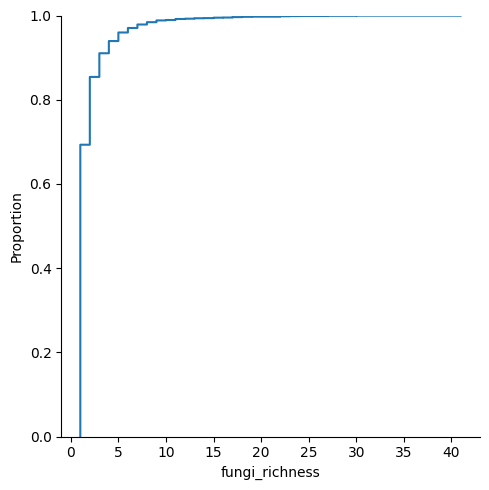

In [73]:
sns.displot(df, x = 'fungi_richness', kind = 'ecdf')
plt.show()

In [74]:
#Prune outliers 

# Get 99% of data
q = df['fungi_richness'].quantile(q = 0.99)
print(q)

df = df[df.fungi_richness <= q]
print(df['fungi_richness'].max())

removed_row = rows_count - df.shape[0]
print(f'Removed {removed_row} rows with fungi_richness over {max}. Now {df.shape[0]}')


11.0
11
Removed 24 rows with fungi_richness over <built-in function max>. Now 2876


In [75]:
#Target Variable 
target = 'fungi_richness'

#Removing fungi shannon as it's highly correlated with target 
#Removing FID as just grid index
df = df.drop(['fungi_shannon','FID'], axis = 1)



#Split datasets
data_with_bias = df 
data_no_bias = dropBiasFeatures(df)


In [76]:
# 1. Load data
# drop block_id, use regionCode for clustering 
#df = df.drop(['block_id'], axis = 1)

spatial_block_feature = 'block_id'
#spatial_block_feature = 'regionCode'

spatial_block_splits = df[spatial_block_feature].nunique()
print(spatial_block_splits)

5


In [77]:
# User-defined nominal features (only if present in dataset)

def get_feature_lists(df):
    all_feats = [c for c in df.columns if c not in [target, spatial_block_feature]]
    nominal_feats = []
    numeric_feats = []
    
    for col in df.columns:
        if col != target:   
            if df[col].dtype == 'object':
                nominal_feats.append(col) 
            else:
                numeric_feats.append(col)

    return nominal_feats, numeric_feats


In [78]:
def prepare_pipeline(nominal_feats, numeric_feats):
    # Numeric: impute + scale
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    # Nominal: impute + one-hot
    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_feats),
        ('nom', nominal_transformer, nominal_feats)
    ], remainder='drop')
    pipeline = Pipeline([
        ('preproc', preprocessor),
        ('rf', RandomForestRegressor(random_state=42))
    ])
    return pipeline


In [79]:
# 3. CV schemes and hyperparameters
grid_params = {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 10, 15]
}
cv_spatial = GroupKFold(n_splits=spatial_block_splits)
cv_strat = KFold(n_splits=spatial_block_splits, shuffle=True, random_state=42)
datasets = {'with_bias': data_with_bias, 'no_bias': data_no_bias}
results = {}


In [80]:
# 4. Grid searches
def run_searches():
    for label, df in datasets.items():
        # Dynamic feature lists
        nom_feats, num_feats = get_feature_lists(df)
        X = df[nom_feats + num_feats].copy()
        # Ensure nominal columns are string for uniform encoding
        for col in nom_feats:
            X[col] = X[col].astype(str)
        y = df[target]
        groups = df.get(spatial_block_feature, None)

        for cv_name, cv in [('random', cv_strat), ('spatial', cv_spatial)]:
            pipe = prepare_pipeline(nom_feats, num_feats)
            gs = GridSearchCV(pipe, grid_params, cv=cv, scoring='r2', n_jobs=-1)
            if cv_name == 'spatial' and groups is not None:
                gs.fit(X, y, groups=groups)
            else:
                gs.fit(X, y)
            results[(label, cv_name)] = (gs, nom_feats, num_feats)
            

In [81]:

# Run
run_searches()


In [82]:
def interpretGridSearch(results):
    # Model performance 
    for index, ((label, cv_name), (gs, nom_feats, num_feats)) in enumerate(results.items()):
            print(index)
            title = f"=== {label} | {cv_name} ==="
            df = datasets[label]
            X = df[nom_feats + num_feats].copy()
            for col in nom_feats:
                X[col] = X[col].astype(str)
            y = df[target]

            print(title)
            print("Best params:", gs.best_params_)
            print("Best R²:", gs.best_score_)

            model = gs.best_estimator_
            feature_names = model[:-1].get_feature_names_out()
            importances = model.named_steps['rf'].feature_importances_
            sorted_idx = importances.argsort()[::-1]

            top_feature = feature_names[sorted_idx][0]
            print(top_feature)
            top_feature_pretty = top_feature.split('__')[1]

            top_feature_pretty = top_feature

            print(feature_names[sorted_idx][:10])
            """
            plt.bar(range(10), importances[sorted_idx][:10])
            plt.xticks(range(10), feature_names[sorted_idx][:10])
            plt.title(title)
            plt.tight_layout()

            PartialDependenceDisplay.from_estimator(
                model,
                X,
                features=[top_feature_pretty],  # replace with actual name
                feature_names=feature_names,
            )


            pred = model.predict(X)
            residuals = y - pred
            plt.figure(figsize=(8, 5))
            #sns.scatterplot(x=X[top_feature_pretty], y=residuals)
            plt.axhline(0, color='red')
            plt.title(f"Residuals vs {top_feature_pretty}")
            plt.xlabel(top_feature_pretty)
            plt.ylabel("Residuals")
            """
            plt.show()





In [83]:
#print(results)
if results:
    interpretGridSearch(results)

0
=== with_bias | random ===
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 200}
Best R²: 0.02990927576565916
num__bioclim_10
['num__bioclim_10' 'num__distanceRo' 'num__populationDensity'
 'num__bioclim_03' 'num__tree_shannon_index' 'num__bioclim_15'
 'num__tree_diver' 'num__hauteur' 'num__distanceToUrban' 'num__bioclim_01']
1
=== with_bias | spatial ===
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 300}
Best R²: -0.3700519800366431
num__bioclim_10
['num__bioclim_10' 'num__distanceRo' 'num__populationDensity'
 'num__bioclim_03' 'num__bioclim_15' 'num__tree_shannon_index'
 'num__tree_diver' 'num__hauteur' 'num__bioclim_01' 'num__distanceToUrban']
2
=== no_bias | random ===
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 200}
Best R²: 0.03448581759781892
num__bioclim_10
['num__bioclim_10' 'num__bioclim_15' 'num__tree_shannon_index'
 'num__tree_diver' 'num__bioclim_03' 'num__hauteur' 'num__bioclim_01'
 'num__cl_age_et' 'num__bioclim_04' 'num__bioclim_08']
3
=== no_

In [84]:
"""


Interpretation:

If the PDP for dist_to_road shows a steep drop in predicted “presence probability” as distance increases (e.g., highest probability right by roads, then plummets),
that suggests RF is heavily “learning” the bias.

If the PDP for bio1 shows, say, an optimum at 20 °C, that suggests a true ecological response to temperature.
"""

'\n\n\nInterpretation:\n\nIf the PDP for dist_to_road shows a steep drop in predicted “presence probability” as distance increases (e.g., highest probability right by roads, then plummets),\nthat suggests RF is heavily “learning” the bias.\n\nIf the PDP for bio1 shows, say, an optimum at 20 °C, that suggests a true ecological response to temperature.\n'

In [85]:
# Keep best model 

if results:
    best_grid = ()
    for index, ((label, cv_name), (gs, nom_feats, num_feats)) in enumerate(results.items()):
        grid_title = f"{label} - {cv_name}"
        if not best_grid:
             best_grid = (grid_title, gs)
             
        if gs.best_score_ > best_grid[1].best_score_:
                best_grid = (grid_title,gs)
     
print(best_grid[0])
model = best_grid[1].best_estimator_
print(model)


no_bias - random
Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cl_dens', 'cl_haut',
                                                   'cl_age_et', 'cl_pent',
                                                   'hauteur', 'cl_drai',
                                                   'tree_diver',
                                                   'tree_shannon_index',
                                                   'regionCode', 'bioclim_01',
                                                   'bioclim_02', 'bioclim_03',
                                                   'b

In [86]:
# 1. Load test data

test_df = pd.read_csv("/home/egodin/Documents/projects/mycoCarte/data/interim/model/testData.csv", index_col= 0)
rows_count = test_df.shape[0]
print(rows_count)

if 'no_bias' in best_grid[0]:
    print('No bias model, dropping biases features')
    test_df = dropBiasFeatures(test_df)

608492
No bias model, dropping biases features


In [87]:

y_pred = model.predict(test_df)
print('Prediction done on test_data')

test_df['predicted_fungi_richness'] = y_pred
out_df = test_df[['FID', 'predicted_fungi_richness']]
print(out_df.head())

out_df.to_csv('/home/egodin/Documents/projects/mycoCarte/data/output/speciesRichnessPrediction.csv')
print('Prediction written to disk')

Prediction done on test_data
     FID  predicted_fungi_richness
264  264                  2.330027
265  265                  2.641534
266  266                  1.431903
267  267                  1.669796
268  268                  1.642792
Prediction written to disk
